In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import numpy as np
import math
from shutil import copy
import imutils

In [2]:
src = 'pretrained_model/vie.traineddata'
dst = '/usr/share/tesseract/tessdata'
copy(src, dst)

'/usr/share/tesseract/tessdata/vie.traineddata'

In [3]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [4]:
img = cv2.imread('../image/cccd/DTN_Shot.jpg', cv2.IMREAD_GRAYSCALE)

# thres, thres_img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(img.shape)

(1811, 2561)


# Detect edge using houghline

#Scale the image, using houghline to detect line of edges and then apply perspecrive transform

# Testing, Showing, Tweaking Parameters For HoughLines

(3024, 4032, 3)


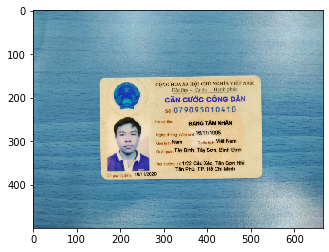

In [5]:
# TCT, NDMT
img_edge = cv2.imread('../image/cccd/DTN_CCCD_Shot2.jpg', cv2.IMREAD_COLOR)
print(img_edge.shape)
ratio = img_edge.shape[0] / 500.0
orig = img_edge.copy()
img_edge = imutils.resize(img_edge, height = 500)
show_image(img_edge)

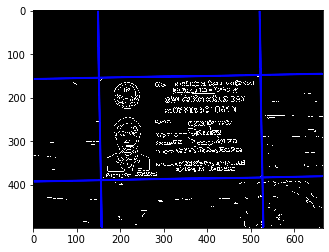

In [6]:
gray = cv2.cvtColor(img_edge, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(img_edge, (3, 3), 3)

dst = cv2.Canny(gray, 50, 100, None, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLines(dst, 1, np.pi / 180, 140, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        cv2.line(cdst, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

# cv2_imshow(out)
# cv2_imshow(cdst)
show_image(cdst)

In [7]:
pts = []
for i in range(lines.shape[0]):
    (rho1, theta1) = lines[i, 0]
    m1 = -1 / np.tan(theta1)
    c1 = rho1 / np.sin(theta1)
    for j in range(i + 1, lines.shape[0]):
        (rho2, theta2) = lines[j, 0]
        m2 = -1 / np.tan(theta2)
        c2 = rho2 / np.sin(theta2)
        if np.abs(m1 - m2) <= 1e-8:
            continue
        x = (c2 - c1) / (m1 - m2)
        y = m1 * x + c1
        if 0 <= x < cdst.shape[1] and 0 <= y < cdst.shape[0]:
            pts.append((int(x), int(y)))

In [8]:
pts_corner = []
sorted_pts_x_axis = sorted(pts, key=lambda tup: tup[0])
sorted_pts_y_axis = sorted(pts, key=lambda tup: tup[1])

x_thres = (sorted_pts_x_axis[0][0] + sorted_pts_x_axis[-1][0]) / 2
y_thres = (sorted_pts_y_axis[0][1] + sorted_pts_y_axis[-1][1]) / 2

right = []
left = []

for i in range(len(pts)):
    if pts[i][0] <= x_thres:
        right.append(pts[i])
    else:
        left.append(pts[i])

In [9]:
centre_pt = (x_thres, y_thres)


def distance(pt1, pt2):
    pt1_ls = list(pt1)
    pt2_ls = list(pt2)

    return math.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

In [10]:
right_up = []
right_down = []
for i in range(len(right)):
    if right[i][1] <= y_thres:
        right_up.append(right[i])
    else:
        right_down.append(right[i])

thresh = -1
for i in range(len(right_up)):
    dist = distance(right_up[i], centre_pt)
    if dist > thresh:
        thresh = dist
        right_up_corner = right_up[i]
pts_corner.append(right_up_corner)

thresh = -1
for i in range(len(right_down)):
    dist = distance(right_down[i], centre_pt)
    if dist > thresh:
        thresh = dist
        right_down_corner = right_down[i]
pts_corner.append(right_down_corner)

In [11]:
left_up = []
left_down = []
for i in range(len(left)):
    if left[i][1] <= y_thres:
        left_up.append(left[i])
    else:
        left_down.append(left[i])

thresh = -1
for i in range(len(left_down)):
    dist = distance(left_down[i], centre_pt)
    if dist > thresh:
        thresh = dist
        left_down_corner = left_down[i]
pts_corner.append(left_down_corner)

thresh = -1
for i in range(len(left_up)):
    dist = distance(left_up[i], centre_pt)
    if dist > thresh:
        thresh = dist
        left_up_corner = left_up[i]
pts_corner.append(left_up_corner)

In [12]:
pts_np = np.array(pts_corner)
pts_use = pts_np[:,None] # We need to convert to a 3D numpy array with a singleton 2nd dimension
hull = cv2.convexHull(pts_use)

print(hull)

[[[526 383]]

 [[155 390]]

 [[151 155]]

 [[522 148]]]


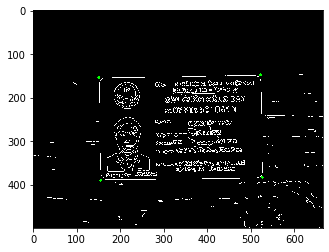

In [13]:
out2 = np.dstack([dst, dst, dst])
for pt in hull[:,0]:
    cv2.circle(out2, tuple(pt), 2, (0, 255, 0), 2)

show_image(out2)

In [14]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [15]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

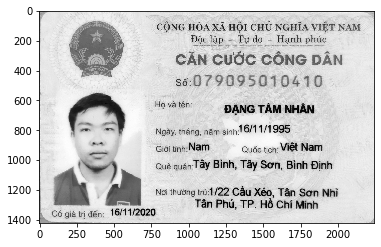

In [16]:
corner_arr = np.asarray(pts_corner, dtype = "float32")
warped = four_point_transform(orig, corner_arr * ratio)
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
show_image(warped)

# Prepocessing image then apply tesseract

In [17]:
# Sharpened the images
def unsharp_mask(image, kernel_size, sigma, amount, threshold):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

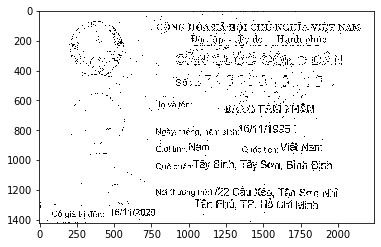

In [18]:
thres_img = cv2.adaptiveThreshold(warped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,13)
show_image(thres_img)

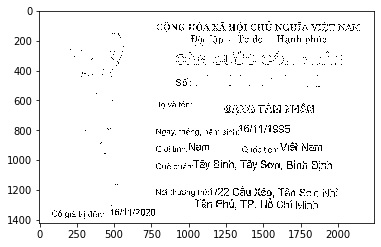

In [19]:
blur = cv2.medianBlur(thres_img,5)
show_image(blur)

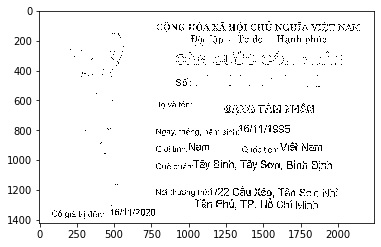

In [20]:
sharpened = unsharp_mask(blur, (5,5), 150, 50, 150)
show_image(sharpened)

# Calculate histogram then group them. Only used for part where most information reside and have no actual standard format. Ignore this part for now

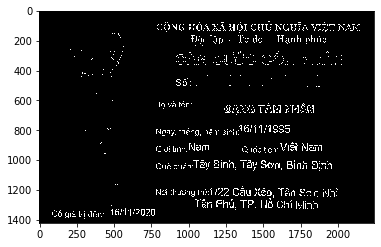

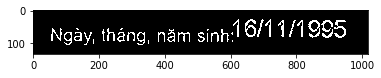

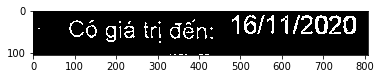

In [21]:
# If some information is missing, changing the ratio
bin_img = ~sharpened

ratio_x_1 = 2.7/8.6
ratio_x_2 = 3.1/8.6
ratio_y_1 = 1.5/5.4
ratio_y_2 = 5.035/5.4
ratio_y_3 = 5.0/5.4

ratio_x_dob_beg = 2.8/8.6
ratio_x_dob_end = 6.7/8.6

ratio_y_dob_beg = 2.8/5.4
ratio_y_dob_end = 3.3/5.4

# part_1 = bin_img[int(bin_img.shape[0]*ratio_y_1):int(bin_img.shape[0]*ratio_y_2),
#                  int(bin_img.shape[1]*ratio_x_1):]

part_1 = bin_img[int(bin_img.shape[0]*ratio_y_dob_beg):int(bin_img.shape[0]*ratio_y_dob_end),
                 int(bin_img.shape[1]*ratio_x_dob_beg):int(bin_img.shape[1]*ratio_x_dob_end)]
                                                          
part_2 = bin_img[int(bin_img.shape[0]*ratio_y_3):,
                 :int(bin_img.shape[1]*ratio_x_2)]

show_image(part_1)
show_image(part_2)

In [22]:
# For part 2 just simply apply tesseract provided the image is clear enough
text = pytesseract.image_to_string(~part_2, lang = 'vie')
print(text)

Có giá trị đến: 16/11/2020
